In [1]:
#pip install highlight-text

Note: you may need to restart the kernel to use updated packages.


In [3]:
#pip install adjustText

  Preparing metadata (setup.py) ... done
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7074 sha256=98ebb2452cde7a166cfa69bdcc3c41737136064cd5792f073329b5be557211a0
  Stored in directory: /Users/shub1801/Library/Caches/pip/wheels/6b/1d/79/4326d5f3a7d86fb9900e5564e7a0f98b552da5103ca762f24f
Successfully built adjustText
Note: you may need to restart the kernel to use updated packages.


In [5]:
#pip install mplsoccer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats


from mplsoccer import Pitch

from PIL import Image
import urllib
import os

In [11]:
df = pd.read_csv('/Users/shub1801/Downloads/longball.csv')

In [15]:
df = (df.groupby(['player_id', 'player_first_name', 'player_last_name'])
    [['minutes', 'long_balls_att', 'long_balls_succ']].sum()
    .reset_index())
df.head()

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ
0,23354,Ashley,Young,693,45,21
1,30893,Cristiano,Ronaldo,180,2,1
2,37234,Adam,Lallana,110,2,1
3,37549,Joao,Moutinho,931,51,34
4,38807,James,Milner,432,34,18


Filtering players above the median in both minutes and long balls attempted

In [14]:
df_plot = df[(df['minutes'] >= df['minutes'].median()) & (df['long_balls_att'] >= df['long_balls_att'].median())]
df_plot.head()

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ
0,23354,Ashley,Young,693,45,21
3,37549,Joao,Moutinho,931,51,34
5,43248,Jonny,Evans,810,67,39
8,72541,César,Azpilicueta,561,22,3
10,80562,Thiago,Silva,990,107,58


In [16]:
df_plot = df_plot.assign(per_90 = lambda x: (x.long_balls_att/x.minutes)*90)
df_plot = df_plot.assign(succ_rate = lambda x: x.long_balls_succ/x.long_balls_att)

In [18]:
df_plot.sort_values(by='per_90').head()

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ,per_90,succ_rate
328,961995,Bukayo,Saka,907,16,12,1.587652,0.750000
159,532743,Philip,Billing,888,21,7,2.128378,0.333333
109,351860,Aleksandar,Mitrovic,803,19,12,2.129514,0.631579
181,599353,Che,Adams,797,19,16,2.145546,0.842105
154,523825,Jarrod,Bowen,1072,26,16,2.182836,0.615385


In [19]:
df_plot['zscore'] = stats.zscore(df_plot['per_90'])*.4 + stats.zscore(df_plot['succ_rate'])*.6
df_plot['annotated'] = [True if x > df_plot['zscore'].quantile(.8) else False for x in df_plot['zscore']]

In [20]:
df_plot[df_plot['player_last_name'] == 'Bowen']

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ,per_90,succ_rate,zscore,annotated
154,523825,Jarrod,Bowen,1072,26,16,2.182836,0.615385,-0.041325,False


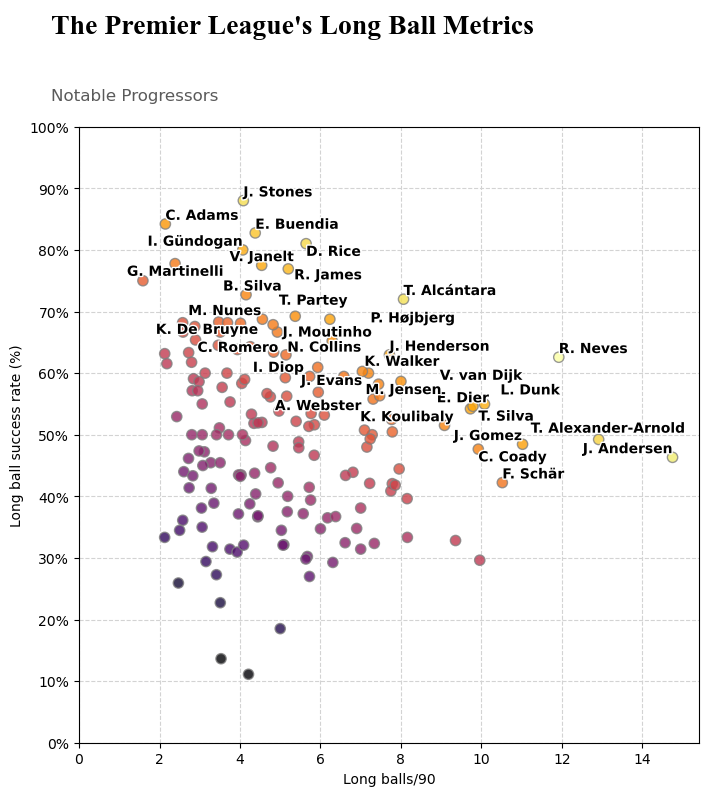

In [33]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.subplot()
ax.grid(visible=True, ls='--', color='lightgrey')

ax.scatter(
    df_plot['per_90'], df_plot['succ_rate'], 
    c=df_plot['zscore'], cmap='inferno', 
    zorder=3, ec='grey', s=55, alpha=0.8)
    
texts = []
annotated_df = df_plot[df_plot['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    texts += [
        ax.text(
            x=annotated_df['per_90'].iloc[index], y=annotated_df['succ_rate'].iloc[index],
            s=f"{annotated_df['player_first_name'].iloc[index][0]}. {annotated_df['player_last_name'].iloc[index]}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='DM Sans', weight='bold'
        )
    ]

adjust_text(texts, only_move={'points':'y', 'text':'xy', 'objects':'xy'})

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax.set_xlim(0)
ax.set_ylim(0,1)

ax.set_ylabel('Long ball success rate (%)')
ax.set_xlabel('Long balls/90')

fig_text(x = 0.09, y = .99, s = "The Premier League's Long Ball Metrics",va = "bottom", ha = "left",fontsize = 20, color = "black", font = "Times New Roman", weight = "bold")

fig_text(
    x = 0.09, y = 0.91, 
    s = "Notable Progressors",
    va = "bottom", ha = "left",
    fontsize = 12, color = "#5A5A5A", font = "Karla"
)

plt.savefig("/Users/shub1801/Downloads/longball.png",dpi = 600,facecolor = "#EFE9E6",bbox_inches="tight",edgecolor="none",transparent = False)